In [2]:
import xscen as xs
from xscen.config import CONFIG, load_config

import xclim as xc
from xclim.core import dataflags

import xarray as xr
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import gridspec
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import seaborn as sns

from dask.distributed import Client
import dask

import spirograph.matplotlib as sp
sp.utils.set_mpl_style('ouranos')



load_config('../configuration/paths_ESPO-G_j.yml', '../configuration/config_ESPO-G_RDRS.yml', verbose=(__name__ == '__main__'), reset=True)
pcat = xs.ProjectCatalog(CONFIG['paths']['project_catalog'])
tdd = CONFIG['tdd']

INFO:xscen.config:Updated the config with ../configuration/paths_ESPO-G_j.yml.
INFO:xscen.config:Updated the config with ../configuration/config_ESPO-G_RDRS.yml.


# Health checks

In [161]:
import dask
dask.config.set({'logging.distributed': 'error'})
#,silence_logs= True
with Client(n_workers=4, threads_per_worker=5, memory_limit="6GB", local_directory= '/exec/jlavoie/tmp_ic6/',
            dashboard_address=6786):
    dict_final = pcat.search(processing_level='final', domain='NAM-rdrs').to_dataset_dict(**tdd)
    
    # to make sure that everything has the same coords
    model_ds = dict_final[list(dict_final.keys())[0]]
    for i,ds in dict_final.items():
        print(i)
        for c in model_ds.coords:
            if not model_ds[c].equals(ds[c]):
                print(f"{c} is different.")
                
        xc.core.datachecks.check_daily(ds)
        
        if dataflags.temperature_extremely_high(ds['tasmax']).any().values:
            print('temperature_extremely_high')
        if dataflags.temperature_extremely_low(ds['tasmin'], thresh='100 K').any().values:
            print('temperature_extremely_low')
        if dataflags.negative_accumulation_values(ds['pr']).any().values:
            print('negative_accumulation_values')
        if dataflags.tasmax_below_tasmin(tasmax=ds['tasmax'], tasmin=ds['tasmin']).any().values:
            print('tasmax_below_tasmin')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


CMIP6_ScenarioMIP_NOAA-GFDL_GFDL-ESM4_ssp245_r1i1p1f1_global.NAM-rdrs.final.D
CMIP6_ScenarioMIP_CMCC_CMCC-ESM2_ssp245_r1i1p1f1_global.NAM-rdrs.final.D
CMIP6_ScenarioMIP_NIMS-KMA_KACE-1-0-G_ssp370_r1i1p1f1_global.NAM-rdrs.final.D
time is different.
CMIP6_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp370_r1i1p1f1_global.NAM-rdrs.final.D
CMIP6_ScenarioMIP_INM_INM-CM5-0_ssp245_r1i1p1f1_global.NAM-rdrs.final.D
CMIP6_ScenarioMIP_MIROC_MIROC6_ssp370_r1i1p1f1_global.NAM-rdrs.final.D
CMIP6_ScenarioMIP_BCC_BCC-CSM2-MR_ssp370_r1i1p1f1_global.NAM-rdrs.final.D
CMIP6_ScenarioMIP_MPI-M_MPI-ESM1-2-LR_ssp245_r1i1p1f1_global.NAM-rdrs.final.D
CMIP6_ScenarioMIP_CSIRO_ACCESS-ESM1-5_ssp245_r1i1p1f1_global.NAM-rdrs.final.D
CMIP6_ScenarioMIP_NIMS-KMA_KACE-1-0-G_ssp245_r1i1p1f1_global.NAM-rdrs.final.D
time is different.
CMIP6_ScenarioMIP_NCC_NorESM2-LM_ssp370_r1i1p1f1_global.NAM-rdrs.final.D
CMIP6_ScenarioMIP_DKRZ_MPI-ESM1-2-HR_ssp370_r1i1p1f1_global.NAM-rdrs.final.D
CMIP6_ScenarioMIP_DKRZ_MPI-ESM1-2-HR_ssp245_r1i1p1

# maps

In [3]:
#load all properties from ref, sim, scen
import copy
def maps(option_id, option_region, option_var):
    "Load properties and measures and plot them."
    
    # get data from catalogue
    prop_ref = pcat.search( processing_level=['diag-ref-prop*', 'diag_ref_prop'], domain=option_region, variable=option_var).to_dask()[option_var]
    prop_sim = pcat.search(id= option_id, processing_level='diag-sim-prop*', domain=option_region, variable=option_var).to_dask()[option_var]
    prop_scen = pcat.search(id= option_id, processing_level='diag-scen-prop*', domain=option_region, variable=option_var).to_dask()[option_var]
    meas_sim_prop = pcat.search(id=option_id, processing_level='diag-sim-meas*', domain=option_region, variable=option_var).to_dask()[option_var]
    meas_scen_prop = pcat.search(id=option_id, processing_level='diag-scen-meas*', domain=option_region, variable=option_var).to_dask()[option_var]
    
    
    #transpose
    if 'corr_' in option_var:
        prop_ref=prop_ref.transpose()
        prop_sim=prop_sim.transpose()
        prop_scen=prop_scen.transpose()
        meas_sim_prop=meas_sim_prop.transpose()
        meas_scen_prop=meas_scen_prop.transpose()
        # force the right cbar
        prop_ref.name= prop_ref.name+ " pr"
        prop_sim.name=prop_sim.name+ " pr"
        prop_scen.name=prop_scen.name+ " pr"
        meas_sim_prop.name=meas_sim_prop.name+ " pr"
        meas_scen_prop.name=meas_scen_prop.name+ " pr"
        
    #set colormap
    maxi_prop = max(prop_ref.max().values, prop_scen.max().values, prop_sim.max().values)
    mini_prop = min(prop_ref.min().values, prop_scen.min().values, prop_sim.min().values)
    maxi_meas = float(max(abs(meas_scen_prop).max().values, abs(meas_sim_prop).max().values))

    #plot
    fig = plt.figure(figsize=(15, 8))
    map_proj = ccrs.RotatedPole(pole_longitude=87.59703063964844,
                          pole_latitude=31.758316040039062,
                         )
    gs = gridspec.GridSpec(4, 3)
    ax0= fig.add_subplot(gs[1:3,0],projection=map_proj)
    ax1= fig.add_subplot(gs[:2,1],projection=map_proj)
    ax2= fig.add_subplot(gs[:2,2],projection=map_proj)
    ax3= fig.add_subplot(gs[2:,1],projection=map_proj)
    ax4= fig.add_subplot(gs[2:,2],projection=map_proj)

    plot_kw_prop=dict(add_colorbar=False, vmin=mini_prop,vmax=maxi_prop)
    plot_kw_meas=dict(add_colorbar=False, vmin=-maxi_meas,vmax=maxi_meas)
    features={ 'lakes':{'scale':'110m', 'edgecolor':'black', 'facecolor':'none'},'coastline':{'scale':'50m'}}
    #plot
    # deep copy until bug is fix TODO
    sp.gridmap(prop_ref, ax=ax0, plot_kw=plot_kw_prop, features=copy.deepcopy(features))
    sp.gridmap(prop_sim, ax=ax1, plot_kw=plot_kw_prop, features=copy.deepcopy(features))
    sp.gridmap(prop_scen, ax=ax3, plot_kw=plot_kw_prop, features=copy.deepcopy(features))
    sp.gridmap(meas_sim_prop, ax=ax2, plot_kw=plot_kw_meas,divergent=0, features=copy.deepcopy(features))
    sp.gridmap(meas_scen_prop, ax=ax4, plot_kw=plot_kw_meas,divergent=0, features=copy.deepcopy(features))

    #prop colorbar
    fig.subplots_adjust(bottom=0.1)
    cbar_ax = fig.add_axes([0.15, 0.01, 0.45, 0.03])
    cb1=fig.colorbar(ax0.get_children()[0], cax=cbar_ax,orientation='horizontal')
    cb1.set_label(label=f"{prop_sim.attrs['long_name']} ({prop_sim.attrs['units']})",size=15)
    cb1.ax.tick_params(axis='x', direction='out')
    cb1.outline.set_visible(False)
    
    #meas colorbar
    fig.subplots_adjust(bottom=0.1)
    cbar_ax = fig.add_axes([0.68, 0.01, 0.25, 0.03])
    cb2=fig.colorbar(ax2.get_children()[0], cax=cbar_ax,orientation='horizontal')
    cb2.set_label(label=f"{meas_sim_prop.attrs['long_name']} ({meas_sim_prop.attrs['units']})",size=15)
    
    cb2.ax.tick_params(axis='x', direction='out')
    cb2.outline.set_visible(False)

    

    fs=15
    ax0.set_title('a) Reference property', fontsize=fs)
    ax1.set_title('b) Simulation property', fontsize=fs)
    ax2.set_title('c) Simulation measure', fontsize=fs)
    ax3.set_title('d) Scenario property', fontsize=fs)
    ax4.set_title('e) Scenario measure', fontsize=fs)
    fig.tight_layout(pad=5.0)
    return fig,[ax0,ax1,ax2,ax3,ax4], [cb1,cb2]
    

In [ ]:
option_id ='CMIP6_ScenarioMIP_NIMS-KMA_KACE-1-0-G_ssp370_r1i1p1f1_global'
option_region = 'Magtogoek-rdrs'
option_var = 'q95_pr'
fig, axs, cbs=maps(option_id=option_id, option_region=option_region, option_var=option_var)
cbs[1].set_label("95th quantile of precipitation \n absolute bias "+r"($kg$ $m^{-2}$ $s^{-1}$)", labelpad=12)
cbs[0].set_label("95th quantile of precipitation "+r"($kg$ $m^{-2}$ $s^{-1}$)", labelpad=12)
#cbs[0].set_ticks( direction='out')



/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: Al

In [ ]:
option_id ='CMIP6_ScenarioMIP_MIROC_MIROC6_ssp370_r1i1p1f1_global'
option_region = 'Magtogoek-rdrs'
option_var = 'q99_tasmin'
fig, axs, cbs=maps(option_id=option_id, option_region=option_region, option_var=option_var)
cbs[1].set_label("99th quantile of minimum \n temperature absolute bias "+r"(K)")

In [ ]:
option_id ='CMIP6_ScenarioMIP_CAS_FGOALS-g3_ssp370_r1i1p1f1_global'
option_region = 'Magtogoek-rdrs'
option_var = 'dry_wet_transition'
fig, axs, cbs=maps(option_id=option_id, option_region=option_region, option_var=option_var)
cbs[1].set_label("Transition probability from a dry \n day to a wet day absolute bias")
cbs[0].set_label("Transition probability from a dry day to a wet day")

In [ ]:
option_id ='CMIP6_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp370_r1i1p1f1_global'
option_region = 'Magtogoek-rdrs'
option_var = 'corr_tasmax_tasmin'
fig, axs, cbs=maps(option_id=option_id, option_region=option_region, option_var=option_var)
cbs[1].set_label("Correlation between maximum\n temperature and minimum temperature absolute bias")
cbs[0].set_label("Correlation between maximum temperature and minimum temperature")

In [ ]:
option_id ='CMIP6_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp370_r1i1p1f1_global'
option_region = 'Magtogoek-rdrs'
option_var = 'corr_tasmax_pr'
fig, axs, cbs=maps(option_id=option_id, option_region=option_region, option_var=option_var)
cbs[1].set_label("Correlation between maximum\n temperature and precipitation absolute bias")
cbs[0].set_label("Correlation between maximum temperature and precipitation")

# heatmap

In [ ]:
#assemble all improved into 1 dataset
dict_hm = pcat.search(processing_level='diag-improved', domain= 'Magtogoek-rdrs', experiment='ssp370').to_dataset_dict()
dict_hm= {ds.attrs['cat:source']:ds for name,ds in dict_hm.items()}
ds_merge=xs.diagnostics.measures_improvement_2d(dict_hm)

# select the right order
# ordered list of properties
order = [
        'mean_tasmax','q01_tasmax', 'q99_tasmax', 'mean_tasmin','q01_tasmin','q99_tasmin',
    'mean_pr','q95_pr','q99_pr','dry_spell_freq', 
    'aca_tasmax', 'aca_tasmin','aca_pr',
         'maximum_length_of_warm_spell','wet_wet_transition', 'dry_wet_transition', 'maximum_length_of_dry_spell',
        'corr_tasmax_tasmin','corr_tasmax_pr',
        ]
# name I want to show up on plot
better_name = [
        'mean_tasmax','q01_tasmax', 'q99_tasmax', 'mean_tasmin','q01_tasmin','q99_tasmin',
    'mean_pr','q95_pr','q99_pr','dry_spell_freq', 
    'aca_tasmax', 'aca_tasmin','aca_pr',
         'max_warm_spell','wet_wet', 'dry_wet', 'max_dry_spell',
        'corr_tasmax_tasmin','corr_tasmax_pr',
        ]
# put in the right order
ds_merge= ds_merge.sel(properties=order, realization = np.sort(ds_merge.realization.values))
# change the name
ds_merge['properties']=better_name

ax=sp.heatmap(ds_merge, fig_kw={'figsize':(15,7)},divergent=0.5 , plot_kw={'vmin': 0})
ax.set_xlabel("") # get rid of labels
ax.set_ylabel("")
plt.xticks(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


y=1.025
plt.annotate(r"marginal",fontsize=15,xy=(0.26, y), xycoords='figure fraction')
plt.annotate(r"temporal",fontsize=15,xy=(0.53, y), xycoords='figure fraction')
plt.annotate(r"mv",fontsize=15,xy=(0.705, y), xycoords='figure fraction')
ax2 = plt.gca().secondary_xaxis('top')
ax2.tick_params(axis='x',length=20, direction="out")
ax2.set_xticks([10,17])
plt.setp(ax2.get_xticklabels(), visible=False)


ax.collections[-1].colorbar.set_label(label='Fraction of improved grid cells',size=15)

In [ ]:
#assemble all improved into 1 dataset
dict_hm = pcat.search(processing_level='diag-improved', domain= 'Magtogoek-rdrs', experiment='ssp245').to_dataset_dict()
dict_hm= {ds.attrs['cat:source']:ds for name,ds in dict_hm.items()}
ds_merge=xs.diagnostics.measures_improvement_2d(dict_hm)

# select the right order
# ordered list of properties
order = [
        'mean_tasmax','q01_tasmax', 'q99_tasmax', 'mean_tasmin','q01_tasmin','q99_tasmin',
    'mean_pr','q95_pr','q99_pr','dry_spell_freq', 
    'aca_tasmax', 'aca_tasmin','aca_pr',
         'maximum_length_of_warm_spell','wet_wet_transition', 'dry_wet_transition', 'maximum_length_of_dry_spell',
        'corr_tasmax_tasmin','corr_tasmax_pr',
        ]
# name I want to show up on plot
better_name = [
        'mean_tasmax','q01_tasmax', 'q99_tasmax', 'mean_tasmin','q01_tasmin','q99_tasmin',
    'mean_pr','q95_pr','q99_pr','dry_spell_freq', 
    'aca_tasmax', 'aca_tasmin','aca_pr',
         'max_warm_spell','wet_wet', 'dry_wet', 'max_dry_spell',
        'corr_tasmax_tasmin','corr_tasmax_pr',
        ]
# put in the right order
ds_merge= ds_merge.sel(properties=order, realization = np.sort(ds_merge.realization.values))
# change the name
ds_merge['properties']=better_name

ax=sp.heatmap(ds_merge, fig_kw={'figsize':(15,7)},divergent=0.5 , plot_kw={'vmin': 0})
ax.set_xlabel("") # get rid of labels
ax.set_ylabel("")
plt.xticks(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


y=1.025
plt.annotate(r"marginal",fontsize=15,xy=(0.26, y), xycoords='figure fraction')
plt.annotate(r"temporal",fontsize=15,xy=(0.53, y), xycoords='figure fraction')
plt.annotate(r"mv",fontsize=15,xy=(0.705, y), xycoords='figure fraction')
ax2 = plt.gca().secondary_xaxis('top')
ax2.tick_params(axis='x',length=20, direction="out")
ax2.set_xticks([10,17])
plt.setp(ax2.get_xticklabels(), visible=False)

ax.collections[-1].colorbar.set_label(label='Fraction of improved grid cells',size=15)

In [ ]:
# get mean IMP 
print('q95_pr',ds_merge.sel(properties='q95_pr').improved_grid_points.mean(dim='realization').values)
print('aca_pr',ds_merge.sel(properties='aca_pr').improved_grid_points.mean(dim='realization').values)
print('aca_tasmax', ds_merge.sel(properties='aca_tasmax').improved_grid_points.mean(dim='realization').values)

print('maximum_length_of_warm_spell',ds_merge.sel(properties='max_warm_spell').improved_grid_points.mean(dim='realization').values)
print('maximum_length_of_dry_spell',ds_merge.sel(properties='max_dry_spell').improved_grid_points.mean(dim='realization').values)
print('wet_wet_transition',ds_merge.sel(properties='wet_wet').improved_grid_points.mean(dim='realization').values)
print('dry_wet_transition',ds_merge.sel(properties='dry_wet').improved_grid_points.mean(dim='realization').values)

print('corr_tasmax_tasmin',ds_merge.sel(properties='corr_tasmax_tasmin').improved_grid_points.mean(dim='realization').values)
print('corr_tasmax_pr',ds_merge.sel(properties='corr_tasmax_pr').improved_grid_points.mean(dim='realization').values)

# Domain

In [ ]:
# This is the map projection we want to plot *onto*
import matplotlib.patches as mpatches
map_proj = ccrs.RotatedPole(pole_longitude=87.59703063964844,
                          pole_latitude=31.758316040039062,
                         )

# something to plot as the domain
ds = pcat.search(processing_level='final', source='GFDL-ESM4', experiment='ssp245',
                      variable='tasmax', domain='NAM-rdrs').to_dataset().sel(time='1991-01-01')['tasmax']

ds['time']= ds.indexes['time'].to_datetimeindex()
ax= sp.gridmap(ds.squeeze(),
               fig_kw=dict(figsize=(10,7)),
               projection=map_proj,
               #show_time=True, TODO: add when can choose loc
               features={'coastline':{'scale':'50m'},
                         'lakes':{'scale':'110m','edgecolor':'black','facecolor':'none'}} )


#rectangle for spatial subregion haudenausonee-rdrs-rot
# lat_bnds= [ -14, -8 ]
# lon_bnds= [ 370, 375 ]
# ax.add_patch(mpatches.Rectangle(xy=[lon_bnds[0],lat_bnds[0]],
#                                 width=lon_bnds[1]-lon_bnds[0],
#                                 height=lat_bnds[1]-lat_bnds[0],
#                                 facecolor='none', edgecolor='blue',linewidth=3,
#                                 transform=map_proj))

#rectangle for spatial subregion magtogoek-rdrs
lat_bnds=  [ 41.4, 49.4]  
lon_bnds= [ -92.2, -59.8 ] 
# clunky
# ax.add_patch(mpatches.Rectangle(xy=[lon_bnds[0],lat_bnds[0]],
#                                 width=lon_bnds[1]-lon_bnds[0],
#                                 height=lat_bnds[1]-lat_bnds[0],
#                                 facecolor='none', edgecolor='pink',linewidth=3,
#                                 transform=ccrs.PlateCarree()))
color='green'
ax.plot(np.linspace(lon_bnds[0], lon_bnds[1],15), np.linspace(lat_bnds[0], lat_bnds[0],15),
         color=color, linestyle='-', transform=ccrs.PlateCarree()
         )

ax.plot(np.linspace(lon_bnds[0], lon_bnds[1],15), np.linspace(lat_bnds[1], lat_bnds[1],15),
         color=color, linestyle='-',transform=ccrs.PlateCarree()
         )

ax.plot(np.linspace(lon_bnds[0], lon_bnds[0],15), np.linspace(lat_bnds[0], lat_bnds[1],15),
         color=color, linestyle='-',transform=ccrs.PlateCarree()
         )

ax.plot(np.linspace(lon_bnds[1], lon_bnds[1],15), np.linspace(lat_bnds[0], lat_bnds[1],15),
         color=color, linestyle='-',transform=ccrs.PlateCarree()
         )

ax.collections[-1].colorbar.outline.set_visible(False)

# ensemble variability


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "None" not found.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "None" not found.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "None" not found.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.


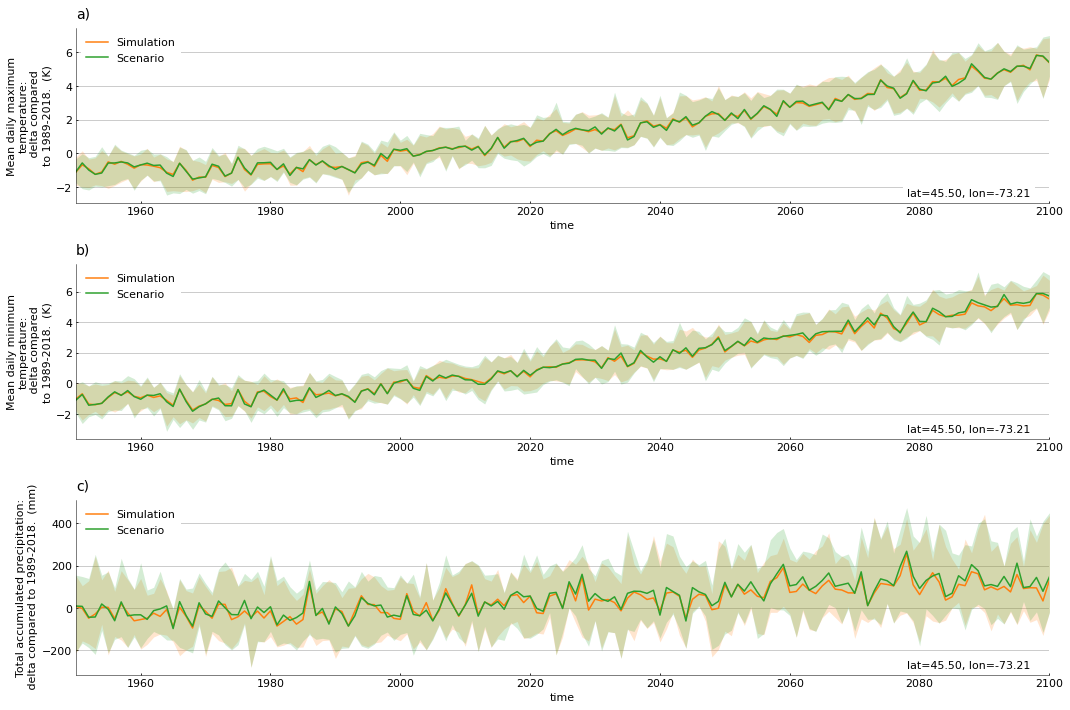

In [4]:
lat= 45.5
lon=-73.5
lat=45.503895
var = 'tx_mean'

func= {'prcptot': 'precip_accumulation',
      'tx_mean':'tx_mean',
      'tn_mean':'tn_mean'}
fig, axs = plt.subplots(3,1, figsize=(15,10))
with xr.set_options(keep_attrs=True):
    for i,(var,title) in enumerate(zip(['tx_mean', 'tn_mean', 'prcptot'],['a)','b)', 'c)'])):
        #get variable and compute indicators
        sim_dict = pcat.search(processing_level='regridded', experiment='ssp370', domain ='QC-rdrs').to_dataset_dict()    
        sim_dict= {i: getattr(xc.atmos, func[var])(ds=ds.where(ds.lat==lat, drop=True)).drop_vars('loc').squeeze()
                   for i,ds in sim_dict.items()}
        # compute anomaly
        sim_dict = {i: ds - ds.sel(time=slice('1989','2018')).mean(dim='time') for i,ds in sim_dict.items()}
        # ensemble stats
        ens_sim = xs.ensembles.ensemble_stats(
                            datasets=sim_dict,
                            statistics={"ensemble_percentiles": {'split': False}},
                            common_attrs_only=False,
                        )[var].to_dataset()


        #same as above but for scen
        scen_dict = pcat.search(processing_level='indicators', domain='QC-rdrs',
                                variable=var, xrfreq='AS-JAN', experiment='ssp370').to_dataset_dict()
        scen_dict = {i: ds.where(ds.lat==lat, drop=True).squeeze() for i,ds in scen_dict.items()}
        scen_dict = {i: ds - ds.sel(time=slice('1989','2018')).mean(dim='time') for i,ds in scen_dict.items()}
        ens_scen = xs.ensembles.ensemble_stats(
                            datasets=scen_dict,
                            statistics={"ensemble_percentiles": {'split': False}},
                            common_attrs_only=False,
                        )[var].to_dataset()
        
        ens_sim[var].attrs['long_name']= f"{ens_sim[var].attrs['long_name']}:\n delta compared to 1989-2018. "


        sp.timeseries({'Simulation': ens_sim[var], 'Scenario': ens_scen[var]},
                  ax =axs[i],
                  use_attrs={'title':None},
                  plot_kw={'Simulation': {'color':'tab:orange',}, 'Scenario': {'color':'tab:green'}})

        sns.move_legend(axs[i], loc='upper left', )
        axs[i].set_title(title, loc='left')
    fig.tight_layout()

# QQ

In [34]:

with (Client(n_workers=3, threads_per_worker=5, memory_limit="15GB",dashboard_address= 6786,local_directory= '/exec/jlavoie/tmp_ic6/'),
     ):
    dom_dict=CONFIG['off-diag']['domains']['Magtogoek-rdrs']
    # get data
    ref= pcat.search(processing_level ='extracted',domain='middle-rdrs-rot', calendar='default').to_dask()
    ref = xs.utils.unstack_fill_nan(ref.sel(time=slice('1989','2018')), coords=['rlat','rlon'])
    ref = xs.spatial.subset(ref.chunk({'time': -1}), dom_dict).chunk(dict(rlat=-1, rlon=-1))

    sim= pcat.search(processing_level ='regridded',domain='middle-rdrs-rot', id = 'CMIP6_ScenarioMIP_INM_INM-CM5-0_ssp370_r1i1p1f1_global').to_dask()
    sim = xs.utils.unstack_fill_nan(sim.sel(time=slice('1989','2018')), coords=['rlat','rlon'])
    sim = xs.spatial.subset(sim.chunk({'time': -1}), dom_dict).chunk(dict(rlat=-1, rlon=-1))
    
    scen= pcat.search(processing_level ='final',domain='NAM-rdrs', id = 'CMIP6_ScenarioMIP_INM_INM-CM5-0_ssp370_r1i1p1f1_global').to_dask()
    scen = xs.spatial.subset(scen.chunk({'time': -1}), dom_dict).sel(time=slice('1989','2018')).chunk(dict(rlat=-1, rlon=-1))
    
    #calculate quantiles
    quantiles = xc.sdba.utils.equally_spaced_nodes(50)
    ref_q={}
    sim_q={}
    scen_q={}
    for var in [ 'tasmax', 'tasmin','pr']:
        if var == 'pr': # only wet days
            ref['pr']=ref.pr.where(ref.pr> 1/86400)
            sim['pr']=sim.pr.where(sim.pr> 1/86400)
            scen['pr']=scen.pr.where(scen.pr> 1/86400)
        ref_q[var]=[]
        sim_q[var]=[]
        scen_q[var]=[]
        for q in quantiles:
            print(q)
            s_q=float(sim[var].quantile(q,skipna=True).values)
            print(s_q)
            ref_q[var].append(float(ref[var].quantile(q,skipna=True).values))
            sim_q[var].append(s_q)
            scen_q[var].append(float(scen[var].quantile(q,skipna=True).values))
print(ref_q)
print(sim_q)
print(scen_q)

/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.


0.01
255.5106201171875
0.03
260.5243225097656
0.05
263.7160339355469
0.06999999999999999
266.0595397949219
0.09
267.90032958984375
0.11
269.3597412109375
0.13
270.55657958984375
0.15000000000000002
271.5400695800781
0.17
272.3409729003906
0.19
272.9720764160156
0.21000000000000002
273.40771484375
0.23
273.7535400390625
0.25
274.2340393066406
0.27
274.8179626464844
0.29000000000000004
275.4779052734375
0.31
276.197509765625
0.33
276.9637451171875
0.35000000000000003
277.75738525390625
0.37
278.56463623046875
0.39
279.3888854980469
0.41000000000000003
280.2237243652344
0.43
281.0689697265625
0.45
281.9205322265625
0.47000000000000003
282.76385498046875
0.49
283.6005859375
0.51
284.40802001953125
0.53
285.1912841796875
0.55
285.957763671875
0.5700000000000001
286.6982116699219
0.59
287.4141845703125
0.61
288.109619140625
0.63
288.7885437011719
0.65
289.4494934082031
0.67
290.09625244140625
0.6900000000000001
290.7245178222656
0.7100000000000001
291.33245849609375
0.73
291.917724609375
0.7

2023-04-20 19:31:34,185 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 11.19 GiB -- Worker memory limit: 13.97 GiB
2023-04-20 19:31:34,262 - distributed.worker.memory - WARNING - Worker is at 77% memory usage. Resuming worker. Process memory: 10.89 GiB -- Worker memory limit: 13.97 GiB
2023-04-20 19:31:34,639 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.89 GiB -- Worker memory limit: 13.97 GiB


0.09
1.436082584405085e-05
0.11
1.506360695202602e-05
0.13
1.580164098413661e-05
0.15000000000000002
1.6577059795963578e-05
0.17
1.739091931085568e-05
0.19
1.8248780179419555e-05


2023-04-20 19:48:29,249 - distributed.worker.memory - WARNING - gc.collect() took 1.181s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-04-20 19:48:29,250 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 11.20 GiB -- Worker memory limit: 13.97 GiB
2023-04-20 19:48:29,494 - distributed.worker.memory - WARNING - Worker is at 78% memory usage. Resuming worker. Process memory: 10.98 GiB -- Worker memory limit: 13.97 GiB


0.21000000000000002
1.915136817842722e-05
0.23
2.0104156646993943e-05


2023-04-20 19:56:27,748 - distributed.worker.memory - WARNING - gc.collect() took 1.060s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-04-20 19:56:27,749 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 11.22 GiB -- Worker memory limit: 13.97 GiB
2023-04-20 19:56:27,821 - distributed.worker.memory - WARNING - Worker is at 78% memory usage. Resuming worker. Process memory: 10.92 GiB -- Worker memory limit: 13.97 GiB


0.25
2.110756940965075e-05
0.27
2.2165009795571677e-05
0.29000000000000004
2.328107802895829e-05
0.31
2.4460243366775103e-05
0.33
2.5710714908200316e-05


2023-04-20 20:13:06,357 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 11.25 GiB -- Worker memory limit: 13.97 GiB
2023-04-20 20:13:06,402 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.27 GiB -- Worker memory limit: 13.97 GiB
2023-04-20 20:13:06,454 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.28 GiB -- Worker memory limit: 13.97 GiB
2023-04-20 20:13:06,553 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memo

0.35000000000000003
2.7038311600335874e-05
0.37
2.8442584643926245e-05
0.39
2.9930468372185715e-05
0.41000000000000003
3.15101282831165e-05
0.43
3.3191414440807425e-05
0.45
3.4982786019099876e-05
0.47000000000000003
3.689388540806249e-05
0.49
3.894039324222831e-05
0.51
4.11281369815697e-05
0.53
4.348153972387082e-05
0.55
4.600528336595744e-05


2023-04-20 21:08:05,204 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 11.23 GiB -- Worker memory limit: 13.97 GiB
2023-04-20 21:08:05,659 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.44 GiB -- Worker memory limit: 13.97 GiB
2023-04-20 21:08:05,750 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.47 GiB -- Worker memory limit: 13.97 GiB
2023-04-20 21:08:05,861 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Proces

0.5700000000000001
4.872899444308132e-05
0.59
5.166120899957605e-05


2023-04-20 21:18:12,689 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 11.24 GiB -- Worker memory limit: 13.97 GiB
2023-04-20 21:18:12,732 - distributed.worker.memory - WARNING - Worker is at 78% memory usage. Resuming worker. Process memory: 10.94 GiB -- Worker memory limit: 13.97 GiB
2023-04-20 21:18:13,224 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.94 GiB -- Worker memory limit: 13.97 GiB
2023-04-20 21:18:13,250 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanage

0.61
5.483595305122435e-05
0.63
5.8283992984797806e-05
0.65
6.202682561706752e-05
0.67
6.614685844397172e-05
0.6900000000000001
7.067787373671308e-05
0.7100000000000001
7.569739980681342e-05
0.73
8.129059278871864e-05
0.75
8.753903603064828e-05
0.77
9.455584950046614e-05
0.79
0.00010253008869767657
0.81
0.00011164987889060289


2023-04-20 21:40:05,400 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 11.19 GiB -- Worker memory limit: 13.97 GiB
2023-04-20 21:40:05,534 - distributed.worker.memory - WARNING - Worker is at 78% memory usage. Resuming worker. Process memory: 10.95 GiB -- Worker memory limit: 13.97 GiB


0.8300000000000001
0.00012226901890244335


2023-04-20 21:41:32,508 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.86 GiB -- Worker memory limit: 13.97 GiB


0.85
0.00013480553752742708


2023-04-20 21:43:18,723 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 11.18 GiB -- Worker memory limit: 13.97 GiB
2023-04-20 21:43:18,880 - distributed.worker.memory - WARNING - Worker is at 77% memory usage. Resuming worker. Process memory: 10.86 GiB -- Worker memory limit: 13.97 GiB
2023-04-20 21:43:18,923 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.86 GiB -- Worker memory limit: 13.97 GiB
2023-04-20 21:43:18,948 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanage

0.87
0.00014971862794482143
0.89
0.00016780460107838728
0.91
0.00019024700217414644
0.93
0.00021854409758816475
0.9500000000000001
0.00025604921393096447
0.97
0.00031240312790032504
0.99
0.00042928951123030875
{'tasmax': [257.16546630859375, 261.8736572265625, 264.395263671875, 266.21875, 267.69012451171875, 268.94647216796875, 270.03668212890625, 270.9998779296875, 271.8599548339844, 272.631103515625, 273.32672119140625, 273.93133544921875, 274.5219421386719, 275.10113525390625, 275.68115234375, 276.2745361328125, 276.8883056640625, 277.52703857421875, 278.18853759765625, 278.8758544921875, 279.583984375, 280.3112487792969, 281.05694580078125, 281.8245849609375, 282.61773681640625, 283.435791015625, 284.27935791015625, 285.13995361328125, 286.00177001953125, 286.8536376953125, 287.6973876953125, 288.52178955078125, 289.31878662109375, 290.0828857421875, 290.81793212890625, 291.5290832519531, 292.22027587890625, 292.89337158203125, 293.55401611328125, 294.2084655761719, 294.86318969726

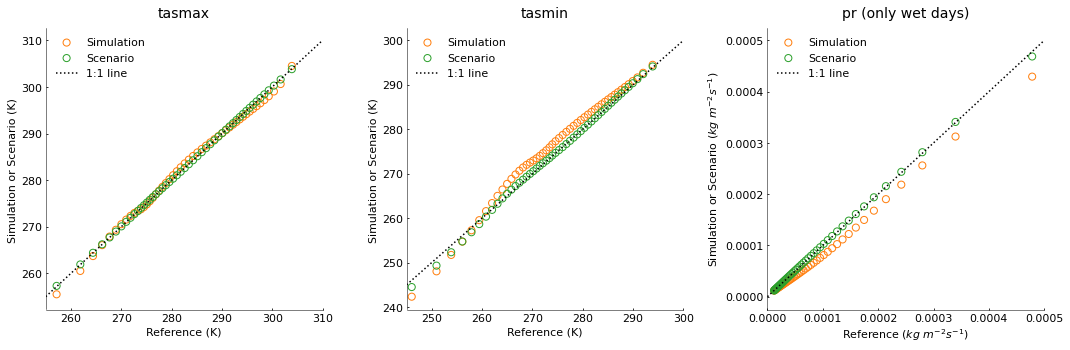

In [60]:
#plot quantiles
# QC-rdrs (copied from above)
#ref_q={'tasmax': [246.85641479492188, 251.3549041748047, 254.39601135253906, 256.9382629394531, 259.1675109863281, 261.110595703125, 262.8271484375, 264.3592834472656, 265.7301025390625, 266.9640808105469, 268.0852355957031, 269.109375, 270.043701171875, 270.89306640625, 271.65606689453125, 272.338134765625, 272.9234619140625, 273.41259765625, 273.86419677734375, 274.31536865234375, 274.772705078125, 275.2410888671875, 275.720458984375, 276.2129821777344, 276.72271728515625, 277.2547607421875, 277.81085205078125, 278.3930358886719, 279.0008544921875, 279.6312255859375, 280.28912353515625, 280.9778137207031, 281.7044677734375, 282.4830627441406, 283.3119812011719, 284.1884765625, 285.10784912109375, 286.0499267578125, 286.99853515625, 287.9428405761719, 288.86883544921875, 289.7752990722656, 290.6700439453125, 291.57415771484375, 292.51580810546875, 293.5406188964844, 294.7030029296875, 296.08056640625, 297.8696594238281, 300.7700500488281], 'tasmin': [238.29998779296875, 243.12904357910156, 245.99972534179688, 248.280029296875, 250.292724609375, 252.14505004882812, 253.8950958251953, 255.56195068359375, 257.12591552734375, 258.581298828125, 259.93109130859375, 261.1900939941406, 262.3685302734375, 263.47161865234375, 264.51312255859375, 265.4935302734375, 266.417236328125, 267.28521728515625, 268.09552001953125, 268.8578186035156, 269.5797119140625, 270.2633056640625, 270.9091796875, 271.5200500488281, 272.1004638671875, 272.65673828125, 273.19342041015625, 273.6693115234375, 274.1783752441406, 274.72418212890625, 275.2803955078125, 275.8363037109375, 276.396728515625, 276.96917724609375, 277.555908203125, 278.158203125, 278.7781982421875, 279.42193603515625, 280.1002502441406, 280.81695556640625, 281.5804443359375, 282.40423583984375, 283.29425048828125, 284.2520446777344, 285.26812744140625, 286.3438415527344, 287.4804382324219, 288.72479248046875, 290.17327880859375, 292.3103332519531], 'pr': [1.1876269127242267e-05, 1.250330842594849e-05, 1.3161622428015108e-05, 1.3852980482624841e-05, 1.458025144529529e-05, 1.5343985069193877e-05, 1.6146737834787928e-05, 1.699058702797629e-05, 1.78788868652191e-05, 1.8814085706253536e-05, 1.979980333999265e-05, 2.0838770069531165e-05, 2.1932954041403718e-05, 2.3087586669134907e-05, 2.4303786631207913e-05, 2.5587431009626004e-05, 2.694159047678113e-05, 2.8372516680974513e-05, 2.988785672641825e-05, 3.149165058857761e-05, 3.319087772979401e-05, 3.4992695873370394e-05, 3.69044064427726e-05, 3.893798202625476e-05, 4.1102915638475685e-05, 4.341197563917376e-05, 4.5883174607297406e-05, 4.853082282352261e-05, 5.1380109653109685e-05, 5.444852286018431e-05, 5.776347461505793e-05, 6.13501833868213e-05, 6.524078344227746e-05, 6.948268855921924e-05, 7.412245031446218e-05, 7.920584903331473e-05, 8.480410906486213e-05, 9.100077295443043e-05, 9.789368050405756e-05, 0.00010559821384958923, 0.00011428952711867169, 0.0001241809077328071, 0.0001355693428195079, 0.00014888581732520846, 0.00016479195066494874, 0.00018439162202412264, 0.0002097012312151491, 0.000244786380790174, 0.00030042180209420566, 0.0004300625785253927]}
#sim_q={'tasmax': [246.17808532714844, 251.09803771972656, 254.27944946289062, 256.8619384765625, 259.118896484375, 261.1891784667969, 263.0709533691406, 264.7655944824219, 266.303466796875, 267.6849670410156, 268.9114074707031, 269.9926452636719, 270.9428405761719, 271.77288818359375, 272.4734191894531, 273.0270080566406, 273.3990783691406, 273.68048095703125, 274.0531311035156, 274.5320129394531, 275.063720703125, 275.6286926269531, 276.212158203125, 276.8077697753906, 277.40753173828125, 278.0089111328125, 278.623291015625, 279.2568359375, 279.9156799316406, 280.6015625, 281.31536865234375, 282.0613708496094, 282.8233337402344, 283.5902099609375, 284.3463439941406, 285.0892639160156, 285.8184814453125, 286.5318298339844, 287.2286682128906, 287.9174499511719, 288.61016845703125, 289.3139343261719, 290.0417175292969, 290.80450439453125, 291.6072082519531, 292.4642333984375, 293.41400146484375, 294.5156555175781, 295.90252685546875, 298.2784729003906], 'tasmin': [236.04588317871094, 240.74598693847656, 243.8740692138672, 246.41966247558594, 248.70599365234375, 250.8358612060547, 252.8689727783203, 254.83714294433594, 256.7257385253906, 258.5513610839844, 260.2917785644531, 261.927001953125, 263.4462585449219, 264.8485412597656, 266.1348571777344, 267.3207092285156, 268.4040222167969, 269.3932189941406, 270.29400634765625, 271.0917053222656, 271.7786560058594, 272.3541564941406, 272.84429931640625, 273.3162841796875, 273.8098449707031, 274.32659912109375, 274.8529968261719, 275.3826599121094, 275.9112243652344, 276.4404296875, 276.9704284667969, 277.5063171386719, 278.05657958984375, 278.627197265625, 279.2228698730469, 279.84326171875, 280.4857482910156, 281.1493835449219, 281.8273620605469, 282.5125732421875, 283.20318603515625, 283.909912109375, 284.6405944824219, 285.402587890625, 286.1978759765625, 287.04534912109375, 287.9939270019531, 289.1018981933594, 290.4924011230469, 292.6342468261719], 'pr': [1.1849920156237204e-05, 1.2420289749570657e-05, 1.3015587683185004e-05, 1.3638220780194386e-05, 1.4289784303400666e-05, 1.4973255929362494e-05, 1.5690016880398616e-05, 1.644197436689865e-05, 1.7232177924597636e-05, 1.806509681046009e-05, 1.8942029782920144e-05, 1.986589631997049e-05, 2.083818253595382e-05, 2.186294659622945e-05, 2.294318073836621e-05, 2.4084414490062046e-05, 2.5293227736256085e-05, 2.6573552531772293e-05, 2.7930278520216234e-05, 2.936802957265172e-05, 3.089761230512522e-05, 3.2526080758543685e-05, 3.426048351684585e-05, 3.611507418099791e-05, 3.810205453191884e-05, 4.023162182420492e-05, 4.2514413507888094e-05, 4.4966527639189735e-05, 4.7610930159862667e-05, 5.0471728172851726e-05, 5.3569974952552015e-05, 5.6934361055027694e-05, 6.059759471099824e-05, 6.459919677581638e-05, 6.898152059875429e-05, 7.381673269264873e-05, 7.918247138150036e-05, 8.517113019479439e-05, 9.186084935208783e-05, 9.941089956555516e-05, 0.00010800281597767025, 0.00011787279800046235, 0.00012935977647430272, 0.00014292939158622175, 0.00015923863975331187, 0.0001792105800996072, 0.00020478126927628206, 0.0002392374452028891, 0.0002908897877205163, 0.0004016960100852885]}
#scen_q={'tasmax': [246.9810333251953, 251.44041442871094, 254.4706573486328, 257.0052185058594, 259.2123107910156, 261.14520263671875, 262.8490295410156, 264.376953125, 265.747802734375, 266.9871826171875, 268.1194152832031, 269.15631103515625, 270.1037902832031, 270.9637756347656, 271.7354736328125, 272.4153137207031, 272.986083984375, 273.4693908691406, 273.92584228515625, 274.37615966796875, 274.8268737792969, 275.2836608886719, 275.752685546875, 276.23809814453125, 276.7427978515625, 277.2689514160156, 277.8189697265625, 278.3924560546875, 278.9906311035156, 279.6157531738281, 280.27044677734375, 280.9563293457031, 281.68536376953125, 282.4671936035156, 283.3008728027344, 284.18487548828125, 285.10955810546875, 286.0588073730469, 287.01361083984375, 287.959228515625, 288.8861083984375, 289.7937316894531, 290.68609619140625, 291.58843994140625, 292.529296875, 293.552490234375, 294.706298828125, 296.0740051269531, 297.84417724609375, 300.7032470703125], 'tasmin': [237.17247009277344, 242.09811401367188, 245.16542053222656, 247.5700225830078, 249.6702880859375, 251.60264587402344, 253.42140197753906, 255.1412811279297, 256.7794189453125, 258.354248046875, 259.87237548828125, 261.3310546875, 262.7043762207031, 263.9672546386719, 265.09716796875, 266.0983581542969, 266.9872131347656, 267.78289794921875, 268.5072326660156, 269.17584228515625, 269.8018493652344, 270.39239501953125, 270.9582214355469, 271.5072937011719, 272.0449523925781, 272.5749206542969, 273.10113525390625, 273.627685546875, 274.1585998535156, 274.6980895996094, 275.2491455078125, 275.8130798339844, 276.3892822265625, 276.979736328125, 277.58355712890625, 278.201171875, 278.8350830078125, 279.49041748046875, 280.1809387207031, 280.9187316894531, 281.7187805175781, 282.58428955078125, 283.5195007324219, 284.52734375, 285.5909729003906, 286.70306396484375, 287.8757629394531, 289.14886474609375, 290.6379699707031, 292.8974304199219], 'pr': [1.1838200407510158e-05, 1.2419300219335128e-05, 1.3082400073471945e-05, 1.382040045427857e-05, 1.4616200132877566e-05, 1.5458699635928497e-05, 1.6345700714737177e-05, 1.727739982015919e-05, 1.82566000148654e-05, 1.9285000234958716e-05, 2.0364499505376443e-05, 2.1498599380720407e-05, 2.2687700038659386e-05, 2.3934999262564816e-05, 2.524659976188559e-05, 2.6626099497661926e-05, 2.807710006891284e-05, 2.960439996968489e-05, 3.121270128758624e-05, 3.290750100859441e-05, 3.469279909040779e-05, 3.657730121631175e-05, 3.856690091197379e-05, 4.0673898183740675e-05, 4.290839933673851e-05, 4.528689896687865e-05, 4.7823799832258373e-05, 5.054090070188977e-05, 5.3467600082512945e-05, 5.6623099226271734e-05, 6.002490044920705e-05, 6.370079790940508e-05, 6.768420280423015e-05, 7.200409891083837e-05, 7.671309867873788e-05, 8.187480125343427e-05, 8.75472032930702e-05, 9.382690041093156e-05, 0.00010079229832626879, 0.00010857440065592527, 0.00011733850260498002, 0.00012729820446111262, 0.00013870850671082735, 0.0001520749065093696, 0.0001680426939856261, 0.00018773639749269933, 0.00021308633615262952, 0.00024809929891489446, 0.00030359061202034354, 0.00042845624382607545]}
#magtogoek rdrs
ref_q={'tasmax': [257.16546630859375, 261.8736572265625, 264.395263671875, 266.21875, 267.69012451171875, 268.94647216796875, 270.03668212890625, 270.9998779296875, 271.8599548339844, 272.631103515625, 273.32672119140625, 273.93133544921875, 274.5219421386719, 275.10113525390625, 275.68115234375, 276.2745361328125, 276.8883056640625, 277.52703857421875, 278.18853759765625, 278.8758544921875, 279.583984375, 280.3112487792969, 281.05694580078125, 281.8245849609375, 282.61773681640625, 283.435791015625, 284.27935791015625, 285.13995361328125, 286.00177001953125, 286.8536376953125, 287.6973876953125, 288.52178955078125, 289.31878662109375, 290.0828857421875, 290.81793212890625, 291.5290832519531, 292.22027587890625, 292.89337158203125, 293.55401611328125, 294.2084655761719, 294.8631896972656, 295.5252990722656, 296.2041015625, 296.9073791503906, 297.6470642089844, 298.439453125, 299.31658935546875, 300.34576416015625, 301.6785583496094, 303.9064636230469], 'tasmin': [246.02537536621094, 250.94630432128906, 253.86196899414062, 256.0809020996094, 257.89642333984375, 259.4403076171875, 260.788818359375, 261.9873352050781, 263.0669860839844, 264.05810546875, 264.9752197265625, 265.83526611328125, 266.64764404296875, 267.4151611328125, 268.14581298828125, 268.84619140625, 269.522705078125, 270.1807861328125, 270.82470703125, 271.4608459472656, 272.100341796875, 272.7582702636719, 273.3943176269531, 273.9518127441406, 274.5931396484375, 275.292236328125, 276.0140075683594, 276.7439270019531, 277.4694519042969, 278.18792724609375, 278.90472412109375, 279.61956787109375, 280.3323974609375, 281.03802490234375, 281.73101806640625, 282.412841796875, 283.08380126953125, 283.74652099609375, 284.401611328125, 285.05029296875, 285.6983642578125, 286.3512878417969, 287.0093994140625, 287.68304443359375, 288.3863525390625, 289.12835693359375, 289.93829345703125, 290.864990234375, 292.01373291015625, 293.8912817382816], 'pr': [1.1933417226828169e-05, 1.2683288332482334e-05, 1.347566649201326e-05, 1.431436827260768e-05, 1.5198605979094282e-05, 1.6132049495354295e-05, 1.7118498362833634e-05, 1.8160838590119968e-05, 1.926083874423057e-05, 2.0421364752110094e-05, 2.1644380467478186e-05, 2.2938471447560003e-05, 2.4304468752234243e-05, 2.5748581683728845e-05, 2.7277344852336686e-05, 2.8893280614283867e-05, 3.060351446038112e-05, 3.241327212890611e-05, 3.432958692428656e-05, 3.6354915209813043e-05, 3.850527660688387e-05, 4.078605095855892e-05, 4.320078369346447e-05, 4.576922219712287e-05, 4.8503060534130774e-05, 5.141636938787997e-05, 5.4524600272998214e-05, 5.784434542874809e-05, 6.139562901807949e-05, 6.520425202324984e-05, 6.929404946276918e-05, 7.369854574790224e-05, 7.843365165172145e-05, 8.354714373126626e-05, 8.90980227268301e-05, 9.513818164123237e-05, 0.0001017336183576844, 0.00010895063314819708, 0.00011692582833347845, 0.00012577669986058027, 0.00013567993941251196, 0.00014686674694530666, 0.0001596915681147948, 0.00017457875772379343, 0.00019228145654778925, 0.00021399128076154744, 0.00024177670944482122, 0.0002797899127472206, 0.00033970599179156125, 0.00047817279235459927]}
sim_q={'tasmax': [255.5106201171875, 260.5243225097656, 263.7160339355469, 266.0595397949219, 267.90032958984375, 269.3597412109375, 270.55657958984375, 271.5400695800781, 272.3409729003906, 272.9720764160156, 273.40771484375, 273.7535400390625, 274.2340393066406, 274.8179626464844, 275.4779052734375, 276.197509765625, 276.9637451171875, 277.75738525390625, 278.56463623046875, 279.3888854980469, 280.2237243652344, 281.0689697265625, 281.9205322265625, 282.76385498046875, 283.6005859375, 284.40802001953125, 285.1912841796875, 285.957763671875, 286.6982116699219, 287.4141845703125, 288.109619140625, 288.7885437011719, 289.4494934082031, 290.09625244140625, 290.7245178222656, 291.33245849609375, 291.917724609375, 292.4887390136719, 293.0517883300781, 293.6106872558594, 294.1661071777344, 294.72613525390625, 295.2895202636719, 295.87615966796875, 296.504150390625, 297.19549560546875, 298.009765625, 299.0375671386719, 300.6293640136719, 304.5168762207031], 'tasmin': [242.3217315673828, 248.02491760253906, 251.71963500976562, 254.7071533203125, 257.2615051269531, 259.5386962890625, 261.576904296875, 263.39208984375, 265.0103454589844, 266.4388122558594, 267.708251953125, 268.8314208984375, 269.8183288574219, 270.672607421875, 271.3952941894531, 271.9987487792969, 272.506103515625, 272.9672546386719, 273.4556579589844, 274.0050354003906, 274.6128234863281, 275.25225830078125, 275.9146728515625, 276.6041259765625, 277.3062438964844, 278.01116943359375, 278.7138671875, 279.4134216308594, 280.09698486328125, 280.77130126953125, 281.4325866699219, 282.0758361816406, 282.6977844238281, 283.3076171875, 283.9033203125, 284.48565673828125, 285.05804443359375, 285.6217041015625, 286.1742248535156, 286.716552734375, 287.2518310546875, 287.78961181640625, 288.33978271484375, 288.9084777832031, 289.5024719238281, 290.1382141113281, 290.8426208496094, 291.6609191894531, 292.7086486816406, 294.50213623046875], 'pr': [1.1856641058329843e-05, 1.244127270183526e-05, 1.3052196254648152e-05, 1.3690726518689189e-05, 1.436082584405085e-05, 1.506360695202602e-05, 1.580164098413661e-05, 1.6577059795963578e-05, 1.739091931085568e-05, 1.8248780179419555e-05, 1.915136817842722e-05, 2.0104156646993943e-05, 2.110756940965075e-05, 2.2165009795571677e-05, 2.328107802895829e-05, 2.4460243366775103e-05, 2.5710714908200316e-05, 2.7038311600335874e-05, 2.8442584643926245e-05, 2.9930468372185715e-05, 3.15101282831165e-05, 3.3191414440807425e-05, 3.4982786019099876e-05, 3.689388540806249e-05, 3.894039324222831e-05, 4.11281369815697e-05, 4.348153972387082e-05, 4.600528336595744e-05, 4.872899444308132e-05, 5.166120899957605e-05, 5.483595305122435e-05, 5.8283992984797806e-05, 6.202682561706752e-05, 6.614685844397172e-05, 7.067787373671308e-05, 7.569739980681342e-05, 8.129059278871864e-05, 8.753903603064828e-05, 9.455584950046614e-05, 0.00010253008869767657, 0.00011164987889060289, 0.00012226901890244335, 0.00013480553752742708, 0.00014971862794482143, 0.00016780460107838728, 0.00019024700217414644, 0.00021854409758816475, 0.00025604921393096447, 0.00031240312790032504, 0.00042928951123030875]}
scen_q={'tasmax': [257.3155517578125, 261.9204406738281, 264.4203796386719, 266.2366638183594, 267.710205078125, 268.9757080078125, 270.087158203125, 271.067138671875, 271.9381408691406, 272.7183532714844, 273.4021301269531, 274.0267028808594, 274.6176452636719, 275.1985168457031, 275.7846984863281, 276.3828125, 276.99761962890625, 277.62579345703125, 278.2708740234375, 278.93560791015625, 279.6168518066406, 280.3204345703125, 281.0506896972656, 281.808837890625, 282.5987548828125, 283.4197998046875, 284.26995849609375, 285.13775634765625, 286.0072937011719, 286.8676452636719, 287.71661376953125, 288.54656982421875, 289.346923828125, 290.1109924316406, 290.8436584472656, 291.5518798828125, 292.2396240234375, 292.909423828125, 293.5683288574219, 294.21826171875, 294.8673400878906, 295.5254821777344, 296.2000427246094, 296.8995056152344, 297.6341857910156, 298.41766357421875, 299.2841796875, 300.297607421875, 301.6106872558594, 303.82037353515625], 'tasmin': [244.49078369140625, 249.3125, 252.3231964111328, 254.74307250976562, 256.8202209472656, 258.65789794921875, 260.33221435546875, 261.85791015625, 263.2341613769531, 264.4405822753906, 265.48974609375, 266.40594482421875, 267.2214050292969, 267.9637756347656, 268.6571960449219, 269.31561279296875, 269.9488220214844, 270.5648498535156, 271.16845703125, 271.7630615234375, 272.350341796875, 272.92889404296875, 273.50079345703125, 274.08221435546875, 274.68450927734375, 275.31646728515625, 275.9828186035156, 276.6759033203125, 277.3908996582031, 278.1151123046875, 278.84326171875, 279.5793762207031, 280.3116455078125, 281.0395202636719, 281.7613220214844, 282.4794006347656, 283.19146728515625, 283.8934326171875, 284.5872802734375, 285.2764587402344, 285.9638671875, 286.6534423828125, 287.34716796875, 288.05029296875, 288.7747497558594, 289.5349426269531, 290.35577392578125, 291.2801818847656, 292.4030456542969, 294.12890625], 'pr': [1.1911700312339235e-05, 1.2640500244742725e-05, 1.3447999663185328e-05, 1.4324699805001728e-05, 1.5259900465025567e-05, 1.6248899555648677e-05, 1.7291000403929502e-05, 1.8390499462839216e-05, 1.9549399439711124e-05, 2.0769499315065332e-05, 2.205320015491452e-05, 2.340440005355049e-05, 2.4821800252539106e-05, 2.6316300136386417e-05, 2.7895799576072022e-05, 2.9558099413407035e-05, 3.131340054096654e-05, 3.316649963380769e-05, 3.512449984555133e-05, 3.719420055858791e-05, 3.938349982490763e-05, 4.17099981859792e-05, 4.4164899009047076e-05, 4.677049946621992e-05, 4.953339885105379e-05, 5.247339868219569e-05, 5.5623400839976966e-05, 5.899219831917435e-05, 6.258219946175814e-05, 6.642450171057135e-05, 7.052790169836953e-05, 7.49336977605708e-05, 7.968029967742041e-05, 8.481999975629151e-05, 9.039750148076564e-05, 9.645459795137867e-05, 0.00010306989861419424, 0.00011034939961973578, 0.00011838920181617141, 0.0001272884983336553, 0.0001371966936858371, 0.0001484184031141922, 0.00016123600653372705, 0.00017615010438021272, 0.00019390109810046852, 0.0002156395057681948, 0.00024358759401366115, 0.00028183040558360517, 0.00034090279950760305, 0.00046857784618623607]}

fig, axs = plt.subplots(1,3, figsize=(15,5))

for var in ['tasmax']:
    axs[0].scatter(ref_q[var], sim_q[var],  s=50,label='Simulation', facecolors='none', edgecolors='tab:orange' )
    axs[0].scatter(ref_q[var], scen_q[var],s=50, label='Scenario', facecolors='none', edgecolors='tab:green' )
    axs[0].plot([255,310],[255,310], 'k:', label='1:1 line')
    axs[0].legend()
    axs[0].set_ylabel('Simulation or Scenario (K) ')
    axs[0].set_xlabel('Reference (K)')
    axs[0].set_title(var)
    axs[0].grid(False)
for var in ['tasmin']:
    axs[1].scatter(ref_q[var], sim_q[var],  s=50,label='Simulation', facecolors='none', edgecolors='tab:orange' )
    axs[1].scatter(ref_q[var], scen_q[var],s=50, label='Scenario', facecolors='none', edgecolors='tab:green' )
    axs[1].plot([245,300],[245,300], 'k:', label='1:1 line')
    axs[1].legend()
    axs[1].set_ylabel('Simulation or Scenario (K) ')
    axs[1].set_xlabel('Reference (K)')
    axs[1].set_title(var)
    axs[1].grid(False)

for var in [ 'pr']:
    axs[2].scatter(ref_q[var], sim_q[var],  s=50,label='Simulation', facecolors='none', edgecolors='tab:orange' )
    axs[2].scatter(ref_q[var], scen_q[var],s=50, label='Scenario', facecolors='none', edgecolors='tab:green' )
    axs[2].plot([0,0.0005],[0,0.0005], 'k:', label='1:1 line')
    axs[2].legend()
    axs[2].set_ylabel(r'Simulation or Scenario ($kg$ $m^{-2} s^{-1}$) ')
    axs[2].set_xlabel(r'Reference ($kg$ $m^{-2} s^{-1}$)')
    axs[2].set_title(f"{var} (only wet days)")
    axs[2].grid(False)
fig.tight_layout()
#plt.savefig(f"{CONFIG['paths']['figures']}qq.png")
